In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
l=[]
ids=[]
for i in os.listdir('/content/drive/MyDrive/AV/'):
  ids.append(i)
  s1 = i+'--veins.jpg'
  s2=i+'--arteries.jpg'
  s3=i+'--artery.jpg'
  if(s1 in os.listdir('/content/drive/MyDrive/AV/'+i)):
    l.append('/content/drive/MyDrive/AV/'+i+'/'+s1)
  # elif (s2 in os.listdir('/content/drive/MyDrive/AV/'+i)):
  #   l.append('/content/drive/MyDrive/AV/'+i+'/'+s2)
  # elif(s3 in os.listdir('/content/drive/MyDrive/AV/'+i)  ):
  #   l.append('/content/drive/MyDrive/AV/'+i+'/'+s3)

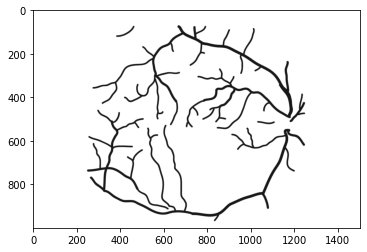

In [3]:
import matplotlib.pyplot as plt
import cv2
img = plt.imread(l[1])
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')

In [4]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
masks = []
for label in tqdm(l):
  img = plt.imread(label)
  mask = cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC)
  gray = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
  masks.append(gray)
masks = np.array(masks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/95 [00:00<?, ?it/s]

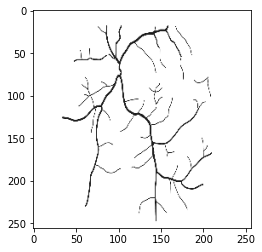

In [5]:
ind = np.random.randint(98)
plt.imshow(masks[ind],cmap='gray')
# masks = np.array(masks)
# masks.shape

In [6]:
impath = []
for i in range(len(l)):
  path = l[i]
  path = path.split('/')
  path[-1]=path[-2]+'.JPG'
  path = '/'.join(path)
  impath.append(path)

In [7]:
images = []
for path in tqdm(impath):
  img = plt.imread(path)
  img = cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC)
  images.append(img)
images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/95 [00:00<?, ?it/s]

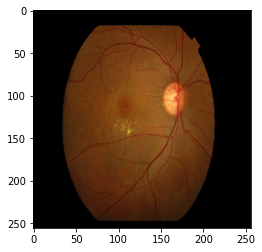

In [8]:
ind = np.random.randint(98)
plt.imshow(images[ind],cmap='gray')
# masks = np.array(masks)
# masks.shape

In [9]:
images.shape

(95, 256, 256, 3)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(images,masks,test_size=0.15,random_state=42)

In [11]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor = 'val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True
)

In [12]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 7.7 MB/s 


In [13]:
import segmentation_models as sm
preprocess_input = sm.get_preprocessing('vgg16')
rX_train=preprocess_input(X_train)
rX_test = preprocess_input(X_test)
from keras.callbacks import EarlyStopping
sm.set_framework('tf.keras')
resnet =  sm.Unet('vgg16')
callback=EarlyStopping(monitor='val_iou_score',mode='max',patience=50,verbose=1,restore_best_weights=True)
resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[sm.metrics.iou_score])
resnet_history=resnet.fit(x=X_train,y=y_train,epochs=1000,callbacks=[])

Segmentation Models: using `keras` framework.
58900480/58889256 [==============================] - 2s 0us/step
Epoch 1/1000
3/3 [==============================] - 43s 5s/step - loss: 351432.9375 - iou_score: 0.5968
Epoch 2/1000
3/3 [==============================] - 2s 549ms/step - loss: 349143.8125 - iou_score: 0.6372
Epoch 3/1000
3/3 [==============================] - 2s 551ms/step - loss: 348732.4062 - iou_score: 0.7194
Epoch 4/1000
3/3 [==============================] - 2s 552ms/step - loss: 348646.5312 - iou_score: 0.7712
Epoch 5/1000
3/3 [==============================] - 2s 553ms/step - loss: 348583.3750 - iou_score: 0.7999
Epoch 6/1000
3/3 [==============================] - 2s 550ms/step - loss: 348524.6875 - iou_score: 0.8233
Epoch 7/1000
3/3 [==============================] - 2s 552ms/step - loss: 348473.0000 - iou_score: 0.8360
Epoch 8/1000
3/3 [==============================] - 2s 553ms/step - loss: 348438.5938 - iou_score: 0.8432
Epoch 9/1000
3/3 [=========================

In [14]:

import pickle as pkl

pkl.dump(resnet,open('./model.pkl','wb'))
# resnet_history=resnet.fit(x=X_train,y=y_train,epochs=500,callbacks=[])


INFO:tensorflow:Assets written to: ram://6e5c785a-4158-4fb7-bc33-7c6dd393a155/assets


In [15]:

def pred(img):
  img = resnet.predict(np.expand_dims(img,axis=0))
  img2 = img[0,:,:,0]
  img2 = img2*255
  im = cv2.threshold(img2, 100, 255, cv2.THRESH_BINARY)[1]
  im = im.astype(int)

  for i in range(256):
    for j in range(256):
      if im[i][j]==0:
        img[i][j][0]=255
        img[i][j][1]=0
        img[i][j][2]=0
  return (im,img)
# return 

In [17]:
(mask,im) = pred(X_test[1])
plt.imshow(im)

IndexError: ignored

In [ ]:
plt.imshow(mask,cmap='gray')

In [ ]:
plt.plot(resnet_history.history['loss'])
# plt.plot(resnet_history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(resnet_history.history['iou_score'])
plt.title('IOU Score')
plt.ylabel('IOU')
plt.xlabel('epoch')
plt.show()